In [1]:
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import re
from functools import reduce
from transliterate import translit, get_available_language_codes
plt.style.use('ggplot')
import seaborn as sns

In [2]:
data = pd.read_csv('andic_dicts.csv')
data = data.drop(['id', 'lang', 'annotator', 'concepticon', 'pos', 'reference', 'definition', 'comments', 'borrowing_source_word', 'borrowing_source_comment', 'source'], axis=1)
data = data[data['bor'] != 1]

c:\users\гриша\appdata\local\programs\python\python37-32\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (10,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
labels = {}
glottocodes_ana = ['bagv1239', 'andi1255', 'akhv1239', 'kara1474', 'tind1238', 'ghod1238']
for gc in glottocodes_ana:
    labels[gc[:4]] = gc

In [4]:
def to_e(x):
    return x.replace('ё', 'е')

In [5]:
def drop_langs(i):
    if i == 'andi1255' or i == 'cham1309':
        return np.nan
    else:
        return i

In [6]:
def clean(x):
    x = translit(x, 'ru')
    if x[0] == '(' and x[-1] == ')':
        return np.nan
    elif 'см.' in x:
        return np.nan
    elif 'то же' in x:
        return np.nan
    else:
        return x

In [7]:
def my_drop(df):
    df = df[df['morphology'] != 'ткед']
    df = df[df['morphology'] != 'собир']
    return df

In [8]:
def clean_meaning(x):
    x = translit(x, 'ru')
    x = re.sub(r'i*', '', x)
    x = re.sub(r'\(.*\)', '', x)
    if re.search(r'\d', x):
        return np.nan
    if 'см. ' in x:
        return np.nan
    if '!' in x:
        return np.nan
    else:
        x = re.sub(r'^\s*', '', x)
        return x

In [9]:
def clean_morph(x):
    x = translit(x, 'ru')
    if 'I' in x:
        return np.nan
    if 'II' in x:
        return np.nan
    if 'III' in x:
        return np.nan
    if x == '':
        return np.nan
    else:
        return x

In [10]:
def morph_to_list(i):
    i = i.replace('(', '').replace(')', '').replace(' ','').replace('.', '')
    if i.split(',')[-1] == '':
        return np.nan
    elif 1 < len(i.split(','))< 5: 
        return i.split(',')[-1]
    else:
        return np.nan

In [11]:
all_morph = data[['lemma', 'ipa', 'morphology', 'meaning_ru', 'glottocode']].dropna()  
all_morph['glottocode'] = all_morph['glottocode'].apply(drop_langs)
all_morph['meaning_ru'] = all_morph['meaning_ru'].apply(to_e)
all_morph['meaning_ru'] = all_morph['meaning_ru'].apply(clean)
all_morph['morphology'] = all_morph['morphology'].apply(morph_to_list)
all_morph = all_morph.reset_index(drop=True)

In [12]:
all_morph.dropna()

,lemma,ipa,morphology,meaning_ru,glottocode
9,а'ва,'a-w-a,/ди,дом,akhv1239
10,а'ва,'a-w-a,/ди,этаж,akhv1239
15,авара',a-w-a-r-'a,-ди,препятствие,akhv1239
23,а'дагене,'a-d-a-ɡ-e-n-e,-ди,карапуз,akhv1239
27,адва,a-dʷ-a,-ди,мусульманский святой,akhv1239
...,...,...,...,...,...
43768,ЭЧВ/Ā́ЙЛЪ’А¹,e-tʃʷ-'aː-j-ɬʲ-a,-áло/-алōта,вешать на что-л.,tind1238
43769,ЭЧВ/Ā́ЙЛЪ’А¹,e-tʃʷ-'aː-j-ɬʲ-a,-áло/-алōта,навесить одежду,tind1238
43776,Э̀ЧИ²,ˌe-tʃ-i,-би,тревога,tind1238
43805,Э̄̀ЛЪ’А²,ˌe-ɬʲ-a,-ā́,опираться на что-л.,tind1238


In [13]:
def clean_tindin_verbs(x):
    if 'та' in x:
        return np.nan
    if '-р' in x:
        return np.nan
    else:
        return x

In [14]:
def get_stats(df):
    df_list = df['morphology'].to_list() 
    c = Counter(df_list)
    return(c)

In [15]:
def plot_stats(c):
    c = dict(Counter(c).most_common(20))
    plt.figure(figsize=(15, 5))
    plt.barh(list(c.keys()), list(c.values()))
    plt.show()

In [16]:
def get_ranks(stats):
    ranks = {}
    stats = dict(Counter(stats).most_common())
    for i in range(len(stats.items())):
        ranks[i+1] = list(stats.items())[i][0]
    return ranks

In [17]:
def detect_noise(x):
    if re.search(r'^-\w*\/*-?\w*', x):
        return x
    elif re.search(r'^–\w*\/*–?\w*', x):
        return x.replace('–', '-')
    elif '-лмнИ' in x:
        return np.nan
    else:
        return np.nan

In [18]:
def clean_kara(x):
    x = x.replace('//', '/')
    x = x.replace('мнII', '')
    x = x.replace('-бахъуᴴт|абди', '-абди')
    x = x.replace('á', 'а')
    x = x.replace('бй1', 'би')
    x = x.replace('ā́', 'а')
    x = x.replace('и́', 'и')
    x = x.replace('ṓ', 'ō')
    x = x.replace('ý', 'у')
    x = x.replace('é', 'е')
    x = x.replace('йби', 'иби')
    x = x.replace('ибй', 'иби')
    x = x.replace('_', '')
    x = x.replace('абй', 'аби')
    x = x.replace('|', '')
    x = x.replace('огрмнч', '')
    x = x.replace('кицIваби', '-аби')
    x = x.replace('къиркъирди', 'ди')
    x = translit(x, 'ru')
    return x.replace('-дй', '-ди')

In [19]:
all_morph = all_morph.dropna()
all_morph['meaning_ru'] = all_morph['meaning_ru'].apply(clean_meaning)
all_morph = all_morph.dropna()
all_morph['morphology'] = all_morph['morphology'].apply(clean_kara)
all_morph = all_morph.dropna().reset_index(drop=True)
all_morph['morphology'] = all_morph['morphology'].apply(clean_tindin_verbs)
all_morph = all_morph.dropna()
all_morph['morphology'] = all_morph['morphology'].apply(detect_noise)
all_morph = all_morph.dropna()
all_morph = all_morph.reset_index(drop=True)

In [20]:
add_rows = []
for idx in range(len(all_morph)):
    morph = all_morph.loc[idx].to_list()[2]
    if '/' in morph:
        for m in morph.split('/'):
            line = all_morph.loc[idx].to_list()
            line[2] = m
            add_rows.append(line)
        all_morph = all_morph.drop([idx])

In [21]:
add_df = pd.DataFrame(add_rows)
add_df.columns = ['lemma', 'ipa', 'morphology', 'meaning_ru', 'glottocode']

In [22]:
all_morph = pd.concat([all_morph, pd.DataFrame(add_df)], ignore_index=True)

In [23]:
all_morph['morphology'] = all_morph['morphology'].apply(detect_noise)
all_morph = all_morph.dropna()

In [24]:
bagv = all_morph[all_morph['glottocode'] == 'bagv1239'].reset_index().dropna()
akhv = all_morph[all_morph['glottocode'] == 'akhv1239'].reset_index().dropna()
kara = all_morph[all_morph['glottocode'] == 'kara1474'].reset_index().dropna()
tind = all_morph[all_morph['glottocode'] == 'tind1238'].reset_index().dropna()
ghod = all_morph[all_morph['glottocode'] == 'ghod1238'].reset_index().dropna()

#kara['morphology'] = kara['morphology'].apply(morph_to_list)
kara = my_drop(kara.dropna()).reset_index(drop=True)

#akhv['morphology'] = akhv['morphology'].apply(morph_to_list)
akhv = my_drop(akhv.dropna()).reset_index(drop=True)

#bagv['morphology'] = bagv['morphology'].apply(morph_to_list)
bagv = my_drop(bagv.dropna()).reset_index(drop=True)

#tind['morphology'] = tind['morphology'].apply(morph_to_list)
tind = my_drop(tind.dropna()).reset_index(drop=True)

#ghod['morphology'] = ghod['morphology'].apply(morph_to_list)
ghod = my_drop(ghod.dropna()).reset_index(drop=True)

for lang in [kara, akhv, tind, bagv, ghod]:
    lang['meaning_ru'] = lang['meaning_ru'].apply(clean_meaning)
    lang['morphology'] = lang['morphology'].apply(clean_morph)
    lang.dropna()
kara = kara.dropna()
akhv = akhv.dropna()
tind = tind.dropna()
bagv = bagv.dropna()
ghod = ghod.dropna()

In [25]:
kara['morphology'] = kara['morphology'].apply(detect_noise)
kara = kara.dropna()
kara['morphology'] = kara['morphology'].apply(clean_kara)

tind['morphology'] = tind['morphology'].apply(detect_noise)
tind = tind.dropna()
tind['morphology'] = tind['morphology'].apply(clean_kara)

bagv['morphology'] = bagv['morphology'].apply(detect_noise)
bagv = bagv.dropna()
bagv['morphology'] = bagv['morphology'].apply(clean_kara)

akhv['morphology'] = akhv['morphology'].apply(detect_noise)
akhv = akhv.dropna()
akhv['morphology'] = akhv['morphology'].apply(clean_kara)

ghod['morphology'] = ghod['morphology'].apply(detect_noise)
ghod = ghod.dropna()
ghod['morphology'] = ghod['morphology'].apply(clean_kara)

Text(0.5, 0, 'кол-во')

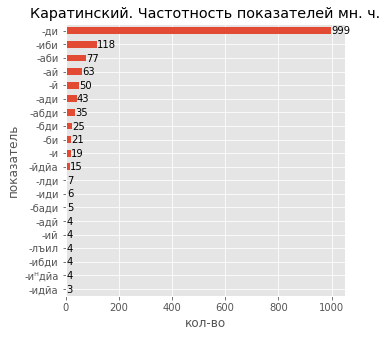

In [26]:
kara_stats = get_stats(kara)
kara_ranks = get_ranks(kara_stats)

plt.figure(figsize=(5, 5))
ax = kara['morphology'].value_counts().head(20).sort_values().plot.barh()
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width(), p.get_y()))
    
plt.title('Каратинский. Частотность показателей мн. ч.')
plt.ylabel('показатель')
plt.xlabel('кол-во')

Text(0.5, 0, 'кол-во')

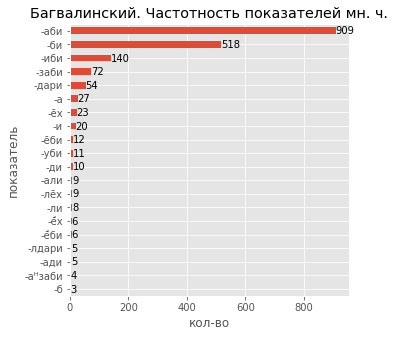

In [27]:
bagv_stats = get_stats(bagv)
bagv_ranks = get_ranks(bagv_stats)

plt.figure(figsize=(5, 5))
ax = bagv['morphology'].value_counts().head(20).sort_values().plot.barh()
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width(), p.get_y()))
    
plt.title('Багвалинский. Частотность показателей мн. ч.')
plt.ylabel('показатель')
plt.xlabel('кол-во')

Text(0.5, 0, 'кол-во')

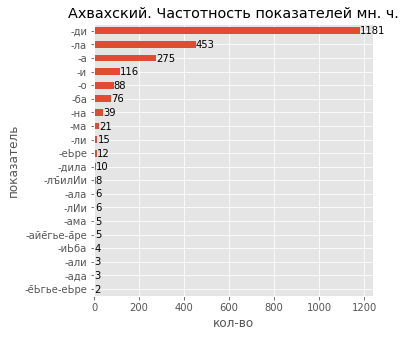

In [28]:
akhv_stats = get_stats(akhv)
akhv_ranks = get_ranks(akhv_stats)

plt.figure(figsize=(5, 5))
ax = akhv['morphology'].value_counts().head(20).sort_values().plot.barh()
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width(), p.get_y()))
plt.title('Ахвахский. Частотность показателей мн. ч.')
plt.ylabel('показатель')
plt.xlabel('кол-во')

Text(0.5, 0, 'кол-во')

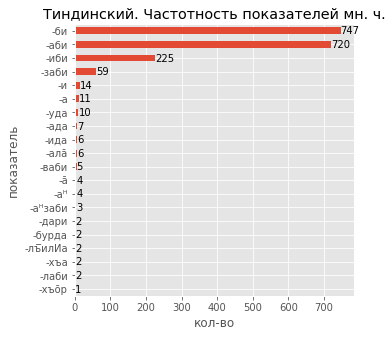

In [29]:
tind_stats = get_stats(tind)
tind_ranks = get_ranks(tind_stats)

plt.figure(figsize=(5, 5))
ax = tind['morphology'].value_counts().head(20).sort_values().plot.barh()
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width(), p.get_y()))

plt.title('Тиндинский. Частотность показателей мн. ч.')
plt.ylabel('показатель')
plt.xlabel('кол-во')

Text(0.5, 0, 'кол-во')

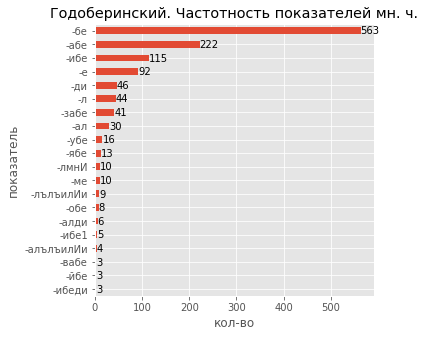

In [30]:
ghod_stats = get_stats(ghod)
ghod_ranks = get_ranks(ghod_stats)

plt.figure(figsize=(5, 5))
ax = ghod['morphology'].value_counts().head(20).sort_values().plot.barh()
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width(), p.get_y()))

plt.title('Годоберинский. Частотность показателей мн. ч.')
plt.ylabel('показатель')
plt.xlabel('кол-во')

In [60]:
ghod[ghod['morphology'] == '-лмнИ']

,index,lemma,ipa,morphology,meaning_ru,glottocode
195,3823,ГЬÁЙГЯ/В,h-'a-j-ɡʲ-a-w,-лмнИ,глупый,ghod1238
273,3901,ГIАЙИБИ́ЙА/В,ʕ-a-j-i-b-'i-j-a-w,-лмнИ,виновный,ghod1238
448,4076,КЪÁДУРУЛIИ,q'-'a-d-u-r-u-tɬ-i,-лмнИ,уважаемый,ghod1238
449,4077,КЪÁДУРУЙА/В,q'-'a-d-u-r-u-j-a-w,-лмнИ,уважаемый,ghod1238
728,4356,ПÁХУРУЛIИ,p-'a-χ-u-r-u-tɬ-i,-лмнИ,высокомерный,ghod1238
729,4357,ПÁХУРУЙА/В,p-'a-χ-u-r-u-j-a-w,-лмнИ,высокомерный,ghod1238
826,4454,ССАЙÁХЪА/Б,sː-a-j-'a-q-a-b,-лмнИ,бродячий,ghod1238
827,4455,ССАЙÁХЪА/Б,sː-a-j-'a-q-a-b,-лмнИ,распутный,ghod1238
1192,8772,ЖАГЬИ́ЛА/В,ʒ-a-h-'i-l-a-w,-лмнИ,неграмотный,ghod1238
1253,8842,РИ́ТIУХЪА/Б,r-'i-t'-u-q-a-b,-лмнИ,справедливый,ghod1238


In [32]:
data_frames = [x.dropna() for x in [kara[['meaning_ru', 'morphology']],
                                    tind[['meaning_ru', 'morphology']],
                                    bagv[['meaning_ru', 'morphology']],
                                    akhv[['meaning_ru', 'morphology']],
                                    ghod[['meaning_ru', 'morphology']],
                                    ]]
               
df_merged_inner = reduce(lambda  left,right: pd.merge(left,right,on=['meaning_ru'],
                                            how='inner'), data_frames).fillna(np.nan)

df_merged_outer = reduce(lambda  left,right: pd.merge(left,right,on=['meaning_ru'],
                                            how='outer'), data_frames).fillna(np.nan)

df_merged_inner.columns = ['meaning_ru',
                     'kara1474',
                     'tind1238',
                     'bagv1239',
                     'akhv1239',
                     'ghod1238'
                     ]
df_merged_outer.columns = ['meaning_ru',
                     'kara1474',
                     'tind1238',
                     'bagv1239',
                     'akhv1239',
                     'ghod1238'
                     ]

In [33]:
df_final = reduce(lambda left,right: pd.merge(left,right,on='meaning_ru'), data_frames)
df_final.columns = ['meaning_ru',
                     'kara1474',
                     'tind1238',
                     'bagv1239',
                     'akhv1239',
                     'ghod1238'
                     ]

In [34]:
def make_correspondence(lang1, lang2, labels=labels):
    columns = ['meaning_ru']
    lang_name1 = lang1['glottocode'].loc[0][:4]
    lang_name2 = lang2['glottocode'].loc[0][:4]
    result = pd.merge(lang1[['meaning_ru', 'morphology']], lang2[['meaning_ru', 'morphology']],on='meaning_ru')
    result = result.reset_index(drop=True)
    columns.append(labels.get(lang_name1))
    columns.append(labels.get(lang_name2))
    result.columns = columns
    result.to_csv(lang_name1 +'_' + lang_name2 + '.csv')
    return result[[labels.get(lang_name1), labels.get(lang_name2)]].value_counts(ascending=True)

In [35]:
kara_tind = make_correspondence(kara, tind)
kara_tind = pd.read_csv('kara_tind.csv').drop('Unnamed: 0', axis=1)

new_kara_ranks = []
for m in kara_tind['kara1474']:
    for r in kara_ranks.items():
        if m == r[1]:
            new_kara_ranks.append(r[0])
new_tind_ranks = []
for m in kara_tind['tind1238']:
    for r in tind_ranks.items():
        if m == r[1]:
            new_tind_ranks.append(r[0])
            
        
kara_tind['kara1474_rank'] = new_kara_ranks
kara_tind['tind1238_rank'] = new_tind_ranks
kara_tind = kara_tind.drop(['kara1474', 'tind1238'], axis=1)

kara_tind = kara_tind[(kara_tind['kara1474_rank'] < 20) & (kara_tind['tind1238_rank'] < 20)]
kara_tind.to_csv('kara_tind_ranks.csv')

,meaning_ru,kara1474,tind1238
0,бревно,-ди,-аби
1,бревно,-аби,-аби
2,бревно,-ди,-аби
3,кукурузные рыльца,-ди,-иби
4,бедро,-абди,-аби
...,...,...,...
729,село,-ай,-би
730,ухо,-ди,-аби
731,ухо,-бди,-аби
732,утюг,-аби,-би


In [36]:
kara_akhv = make_correspondence(kara, akhv)
kara_akhv = pd.read_csv('kara_akhv.csv').drop('Unnamed: 0', axis=1)

new_kara_ranks = []
for m in kara_akhv['kara1474']:
    for r in kara_ranks.items():
        if m == r[1]:
            new_kara_ranks.append(r[0])
new_akhv_ranks = []
for m in kara_akhv['akhv1239']:
    for r in akhv_ranks.items():
        if m == r[1]:
            new_akhv_ranks.append(r[0])
            
        
kara_akhv['kara1474_rank'] = new_kara_ranks
kara_akhv['akhv1239_rank'] = new_akhv_ranks
kara_akhv = kara_akhv.drop(['kara1474', 'akhv1239'], axis=1)

kara_akhv = kara_akhv[(kara_akhv['kara1474_rank'] < 20) & (kara_akhv['akhv1239_rank'] < 20)]
kara_akhv.to_csv('kara_akhv_ranks.csv')

In [37]:
kara_bagv = make_correspondence(kara, bagv)
kara_bagv = pd.read_csv('kara_bagv.csv').drop('Unnamed: 0', axis=1)

new_kara_ranks = []
for m in kara_bagv['kara1474']:
    for r in kara_ranks.items():
        if m == r[1]:
            new_kara_ranks.append(r[0])
new_bagv_ranks = []
for m in kara_bagv['bagv1239']:
    for r in bagv_ranks.items():
        if m == r[1]:
            new_bagv_ranks.append(r[0])
            
        
kara_bagv['kara1474_rank'] = new_kara_ranks
kara_bagv['bagv1239_rank'] = new_bagv_ranks
kara_bagv = kara_bagv.drop(['kara1474', 'bagv1239'], axis=1)

kara_bagv = kara_bagv[(kara_bagv['kara1474_rank'] < 20) & (kara_bagv['bagv1239_rank'] < 20)]
kara_bagv.to_csv('kara_bagv_ranks.csv')

In [38]:
kara_ghod = make_correspondence(kara, ghod)
kara_ghod = pd.read_csv('kara_ghod.csv').drop('Unnamed: 0', axis=1)

new_kara_ranks = []
for m in kara_ghod['kara1474']:
    for r in kara_ranks.items():
        if m == r[1]:
            new_kara_ranks.append(r[0])
new_ghod_ranks = []
for m in kara_ghod['ghod1238']:
    for r in ghod_ranks.items():
        if m == r[1]:
            new_ghod_ranks.append(r[0])
            
        
kara_ghod['kara1474_rank'] = new_kara_ranks
kara_ghod['ghod1238_rank'] = new_ghod_ranks
kara_ghod = kara_ghod.drop(['kara1474', 'ghod1238'], axis=1)

kara_ghod = kara_ghod[(kara_ghod['kara1474_rank'] < 20) & (kara_ghod['ghod1238_rank'] < 20)]
kara_ghod.to_csv('kara_ghod_ranks.csv')

In [39]:
tind_bagv = make_correspondence(tind, bagv)
tind_bagv = pd.read_csv('tind_bagv.csv').drop('Unnamed: 0', axis=1)

new_tind_ranks = []
for m in tind_bagv['tind1238']:
    for r in tind_ranks.items():
        if m == r[1]:
            new_tind_ranks.append(r[0])
new_bagv_ranks = []
for m in tind_bagv['bagv1239']:
    for r in bagv_ranks.items():
        if m == r[1]:
            new_bagv_ranks.append(r[0])
            
        
tind_bagv['tind1238_rank'] = new_tind_ranks
tind_bagv['bagv1239_rank'] = new_bagv_ranks
tind_bagv = tind_bagv.drop(['tind1238', 'bagv1239'], axis=1)

tind_bagv = tind_bagv[(tind_bagv['tind1238_rank'] < 20) & (tind_bagv['bagv1239_rank'] < 20)]
tind_bagv.to_csv('tind_bagv_ranks.csv')

In [40]:
tind_akhv = make_correspondence(tind, akhv)
tind_akhv = pd.read_csv('tind_akhv.csv').drop('Unnamed: 0', axis=1)

new_tind_ranks = []
for m in tind_akhv['tind1238']:
    for r in tind_ranks.items():
        if m == r[1]:
            new_tind_ranks.append(r[0])
new_akhv_ranks = []
for m in tind_akhv['akhv1239']:
    for r in akhv_ranks.items():
        if m == r[1]:
            new_akhv_ranks.append(r[0])
            
        
tind_akhv['tind1238_rank'] = new_tind_ranks
tind_akhv['akhv1239_rank'] = new_akhv_ranks
tind_akhv = tind_akhv.drop(['tind1238', 'akhv1239'], axis=1)

tind_akhv = tind_akhv[(tind_akhv['tind1238_rank'] < 20) & (tind_akhv['akhv1239_rank'] < 20)]
tind_akhv.to_csv('tind_akhv_ranks.csv')

In [41]:
tind_ghod = make_correspondence(tind, ghod)
tind_ghod = pd.read_csv('tind_ghod.csv').drop('Unnamed: 0', axis=1)

new_tind_ranks = []
for m in tind_ghod['tind1238']:
    for r in tind_ranks.items():
        if m == r[1]:
            new_tind_ranks.append(r[0])
new_ghod_ranks = []
for m in tind_ghod['ghod1238']:
    for r in ghod_ranks.items():
        if m == r[1]:
            new_ghod_ranks.append(r[0])
            
        
tind_ghod['tind1238_rank'] = new_tind_ranks
tind_ghod['ghod1238_rank'] = new_ghod_ranks
tind_ghod = tind_ghod.drop(['tind1238', 'ghod1238'], axis=1)

tind_ghod = tind_ghod[(tind_ghod['tind1238_rank'] < 20) & (tind_ghod['ghod1238_rank'] < 20)]
tind_ghod.to_csv('tind_ghod_ranks.csv')

In [42]:
bagv_akhv = make_correspondence(bagv, akhv)
bagv_akhv = pd.read_csv('bagv_akhv.csv').drop('Unnamed: 0', axis=1)

new_bagv_ranks = []
for m in bagv_akhv['bagv1239']:
    for r in bagv_ranks.items():
        if m == r[1]:
            new_bagv_ranks.append(r[0])
new_akhv_ranks = []
for m in bagv_akhv['akhv1239']:
    for r in akhv_ranks.items():
        if m == r[1]:
            new_akhv_ranks.append(r[0])
            
        
bagv_akhv['bagv1239_rank'] = new_bagv_ranks
bagv_akhv['akhv1239_rank'] = new_akhv_ranks
bagv_akhv = bagv_akhv.drop(['bagv1239', 'akhv1239'], axis=1)

bagv_akhv = bagv_akhv[(bagv_akhv['bagv1239_rank'] < 20) & (bagv_akhv['akhv1239_rank'] < 20)]
bagv_akhv.to_csv('bagv_akhv_ranks.csv')

In [43]:
bagv_ghod = make_correspondence(bagv, ghod)
bagv_ghod = pd.read_csv('bagv_ghod.csv').drop('Unnamed: 0', axis=1)

new_bagv_ranks = []
for m in bagv_ghod['bagv1239']:
    for r in bagv_ranks.items():
        if m == r[1]:
            new_bagv_ranks.append(r[0])
new_ghod_ranks = []
for m in bagv_ghod['ghod1238']:
    for r in ghod_ranks.items():
        if m == r[1]:
            new_ghod_ranks.append(r[0])
            
        
bagv_ghod['bagv1239_rank'] = new_bagv_ranks
bagv_ghod['ghod1238_rank'] = new_ghod_ranks
bagv_ghod = bagv_ghod.drop(['bagv1239', 'ghod1238'], axis=1)

bagv_ghod = bagv_ghod[(bagv_ghod['bagv1239_rank'] < 20) & (bagv_ghod['ghod1238_rank'] < 20)]
bagv_ghod.to_csv('bagv_ghod_ranks.csv')

In [44]:
akhv_ghod = make_correspondence(akhv, ghod)
akhv_ghod = pd.read_csv('akhv_ghod.csv').drop('Unnamed: 0', axis=1)

new_akhv_ranks = []
for m in akhv_ghod['akhv1239']:
    for r in akhv_ranks.items():
        if m == r[1]:
            new_akhv_ranks.append(r[0])
new_ghod_ranks = []
for m in akhv_ghod['ghod1238']:
    for r in ghod_ranks.items():
        if m == r[1]:
            new_ghod_ranks.append(r[0])
            
        
akhv_ghod['akhv1239_rank'] = new_akhv_ranks
akhv_ghod['ghod1238_rank'] = new_ghod_ranks
akhv_ghod = akhv_ghod.drop(['akhv1239', 'ghod1238'], axis=1)

akhv_ghod = akhv_ghod[(akhv_ghod['akhv1239_rank'] < 20) & (akhv_ghod['ghod1238_rank'] < 20)]
akhv_ghod.to_csv('akhv_ghod_ranks.csv')

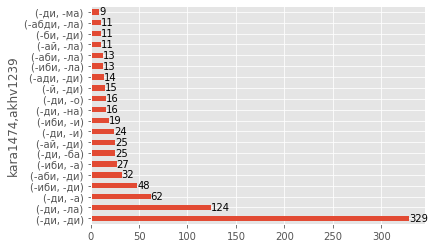

In [45]:
kara_akhv = pd.read_csv('kara_akhv.csv').drop('Unnamed: 0', axis=1)
ax = kara_akhv[['kara1474', 'akhv1239']].value_counts().head(20).plot.barh()
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width(), p.get_y()))

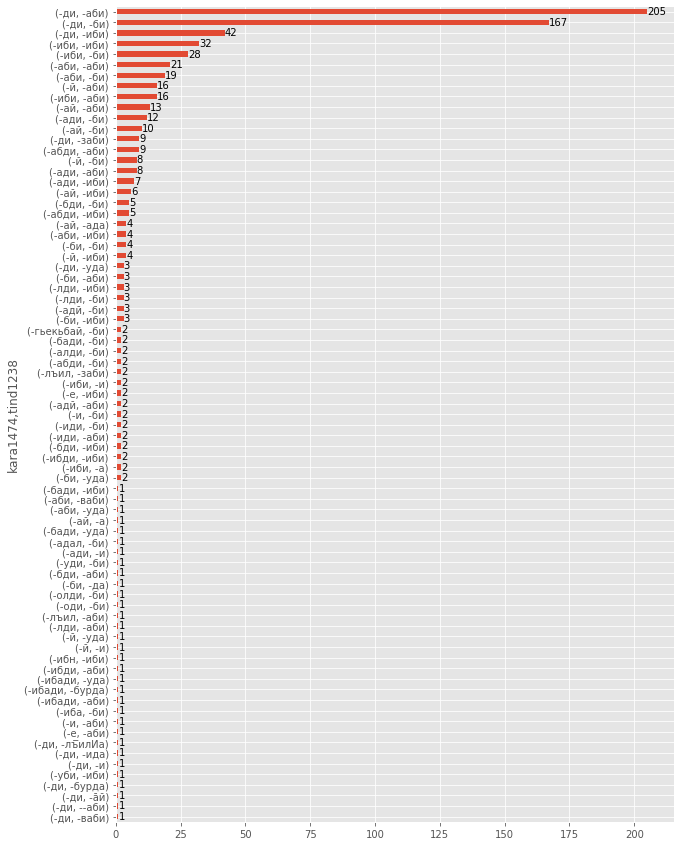

In [46]:
karatind = pd.merge(kara[['meaning_ru', 'morphology']],tind[['meaning_ru', 'morphology']],on='meaning_ru')
karatind = karatind.reset_index(drop=True)
karatind.columns = ['meaning_ru', 'kara1474', 'tind1238']

ax = karatind[['kara1474', 'tind1238']].value_counts(ascending=True).plot.barh(figsize=(10,15))
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width(), p.get_y()))

In [47]:
new_kara_ranks = []
for m in df_merged_inner['kara1474']:
    for r in kara_ranks.items():
        if m == r[1]:
            new_kara_ranks.append(r[0])
new_tind_ranks = []
for m in df_merged_inner['tind1238']:
    for r in tind_ranks.items():
        if m == r[1]:
            new_tind_ranks.append(r[0])
            
new_bagv_ranks = []
for m in df_merged_inner['bagv1239']:
    for r in bagv_ranks.items():
        if m == r[1]:
            new_bagv_ranks.append(r[0])
            
new_akhv_ranks = []
for m in df_merged_inner['akhv1239']:
    for r in akhv_ranks.items():
        if m == r[1]:
            new_akhv_ranks.append(r[0])
        
new_ghod_ranks = []
for m in df_merged_inner['ghod1238']:
    for r in ghod_ranks.items():
        if m == r[1]:
            new_ghod_ranks.append(r[0])
            
df_merged_inner['kara1474_rank'] = new_kara_ranks
df_merged_inner['tind1238_rank'] = new_tind_ranks
df_merged_inner['bagv1239_rank'] = new_bagv_ranks
df_merged_inner['akhv1239_rank'] = new_akhv_ranks
df_merged_inner['ghod1238_rank'] = new_ghod_ranks

In [48]:
df_merged_inner = df_merged_inner.drop_duplicates()

In [49]:
df_merged_inner.to_csv('andi_inner.csv')
#all_morph = all_morph.dropna()

In [50]:
grouped = all_morph[['meaning_ru', 'morphology', 'glottocode']].groupby(['meaning_ru', 'glottocode']).agg(lambda x: list(x))

In [51]:
grouped

morphology
meaning_ru       glottocode              
Абас             tind1238          [-аби]
Багадур          bagv1239         [-заби]
Бика             akhv1239           [-ди]
                 tind1238           [-би]
Вали             ghod1238           [-бе]
...                                   ...
ящерица          bagv1239          [-аби]
ящик, коробка    kara1474           [-ди]
ящичек           kara1474           [-ди]
                 tind1238    [-аби, -аби]
ящичек для ниток kara1474           [-ди]

[7198 rows x 1 columns]

In [52]:
wide_grouped = []
for row in grouped['morphology'].to_list():
    temp_row = []
    new_row = []
    for i in range(len(row)):
        row[i] = row[i].replace('//', '/')
    t = [x.split('/') for x in row]
    flat_list = []
    for sublist in t:
        for item in sublist:
            flat_list.append(item)
    for i in (list((set(flat_list)))):
        new_row.append(i)
    wide_grouped.append(new_row) 
wide_df = pd.DataFrame(wide_grouped)

In [53]:
grouped['morph_1'] = wide_df[0].to_list()
grouped['morph_2'] = wide_df[1].to_list()
grouped['morph_3'] = wide_df[2].to_list()
grouped['morph_4'] = wide_df[3].to_list()
grouped['morph_5'] = wide_df[4].to_list()

In [54]:
grouped.drop('morphology', axis=1).dropna(axis=1, how='all')

morph_1 morph_2 morph_3 morph_4 morph_5
meaning_ru       glottocode                                        
Абас             tind1238      -аби    None    None    None    None
Багадур          bagv1239     -заби    None    None    None    None
Бика             akhv1239       -ди    None    None    None    None
                 tind1238       -би    None    None    None    None
Вали             ghod1238       -бе    None    None    None    None
...                             ...     ...     ...     ...     ...
ящерица          bagv1239      -аби    None    None    None    None
ящик, коробка    kara1474       -ди    None    None    None    None
ящичек           kara1474       -ди    None    None    None    None
                 tind1238      -аби    None    None    None    None
ящичек для ниток kara1474       -ди    None    None    None    None

[7198 rows x 5 columns]

In [55]:
grouped.loc[['отец', 'брат', 'сын']].dropna(axis=1, how='all')

morphology  morph_1
meaning_ru glottocode                     
отец       akhv1239    [-ди, -ди]      -ди
           bagv1239        [-иби]     -иби
           ghod1238        [-абе]     -абе
           kara1474        [-аби]     -аби
           tind1238        [-уда]     -уда
брат       akhv1239         [-ли]      -ли
           bagv1239     [-ӣбади]  -ӣбади
           ghod1238        [-ибе]     -ибе
           kara1474       [-бади]    -бади
           tind1238        [-уда]     -уда
сын        akhv1239         [-ли]      -ли
           bagv1239        [-иби]     -иби
           ghod1238          [-е]       -е
           kara1474          [-й]       -й
           tind1238        [-уда]     -уда

In [74]:
words = [x[0] for x in grouped.index.to_list()]
good_words = []
c = dict(Counter(words).most_common())
for k, v in c.items():
    if v == 5:
        good_words.append(k)

print(good_words)

['барабан', 'барсук', 'бассейн', 'бедняга', 'безрукавка', 'болезнь', 'борода', 'бородавка', 'брат', 'бревно', 'бродяга', 'буйвол', 'бумага', 'бурдюк', 'бычок', 'верблюд', 'веревка', 'веретено', 'ветка', 'вилка', 'вина', 'водосток', 'войско', 'волк', 'ворота', 'вошь', 'выдвижной ящик', 'вымя', 'выход', 'вязанка', 'год', 'голенище', 'голова', 'горло', 'город', 'граница', 'гребень', 'грех', 'грива', 'грудь', 'двор', 'дворец', 'дело', 'день', 'дерево', 'долг', 'дом', 'дочь', 'еж', 'жало', 'желчный пузырь', 'жеребенок', 'жеребец', 'живот', 'загон', 'задача', 'зазубрина', 'замок', 'заноза', 'заявление', 'змея', 'зоб', 'зуб', 'зубец', 'зурна', 'каблук', 'калитка', 'камень', 'капля', 'карман', 'катушка', 'качели', 'кишка', 'клин', 'клык', 'клюв', 'ключ', 'клятва', 'книга', 'кобыла', 'ковер', 'кол', 'колесо', 'колючка', 'копыто', 'корзина', 'корова', 'корыто', 'коса', 'край', 'кромка', 'крыша', 'крышка', 'крючок', 'кукла', 'курдюк', 'курица', 'кусок', 'кутан', 'ладонь', 'лапа', 'ласточка', 'лев

In [57]:
grouped.loc[['мать', 'сестра', 'дочь', 'жена', 'женщина']].dropna(axis=1, how='all')

morphology  morph_1 morph_2 morph_3
meaning_ru glottocode                                               
мать       akhv1239         [-ди, -ди, -ба]      -ди     -ба    None
           bagv1239            [-иби, -иби]     -иби    None    None
           ghod1238                  [-абе]     -абе    None    None
           kara1474                   [-би]      -би    None    None
           tind1238            [-уда, -уда]     -уда    None    None
сестра     akhv1239               [-ли, -о]      -ли      -о    None
           bagv1239               [-ӣбади]  -ӣбади    None    None
           ghod1238                  [-ибе]     -ибе    None    None
           kara1474                [-ибади]   -ибади    None    None
           tind1238    [-аби, -уда, -бурда]     -аби  -бурда    -уда
дочь       akhv1239                   [-ли]      -ли    None    None
           bagv1239                    [-и]       -и    None    None
           ghod1238                  [-ибе]     -ибе    None    None
           kara1474                    [-й]       -й    None    None
           tind1238                    [-и]       -и    None    None
жена       akhv1239          [-о, -ди, -ди]       -о     -ди    None
           ghod1238                  [-ибе]     -ибе    None    None
           kara1474                   [-ай]      -ай    None    None
женщина    akhv1239                    [-о]       -о    None    None
           ghod1238                  [-ибе]     -ибе    None    None
           kara1474                   [-ди]      -ди    None    None

In [58]:
len(good_words)

255

In [59]:
for i in good_words:
    print(grouped.drop('morphology', axis=1).loc[[i]].dropna(axis=1, how='all'))

                      morph_1 morph_2
meaning_ru glottocode                
барабан    akhv1239       -ди     -ба
           bagv1239       -би    None
           ghod1238      -ибе    None
           kara1474        -й    None
           tind1238       -би    None
                      morph_1
meaning_ru glottocode        
барсук     akhv1239       -ди
           bagv1239      -аби
           ghod1238      -обе
           kara1474       -ди
           tind1238       -би
                      morph_1 morph_2
meaning_ru glottocode                
бассейн    akhv1239       -ди      -а
           bagv1239      -аби     -би
           ghod1238      -абе    None
           kara1474       -ди    None
           tind1238       -би    None
                      morph_1 morph_2 morph_3
meaning_ru glottocode                        
бедняга    akhv1239     -мали      -о     -ди
           bagv1239     -заби    None    None
           ghod1238     -забе    None    None
           kara1474       -д

                      morph_1 morph_2
meaning_ru glottocode                
дом        akhv1239       -ди      -а
           bagv1239      -аби     -би
           ghod1238       -бе    None
           kara1474      -лди    None
           tind1238      -аби    -иби
                      morph_1
meaning_ru glottocode        
дочь       akhv1239       -ли
           bagv1239        -и
           ghod1238      -ибе
           kara1474        -й
           tind1238        -и
                      morph_1 morph_2
meaning_ru glottocode                
еж         akhv1239       -ла    None
           bagv1239      -аби    None
           ghod1238      -абе    None
           kara1474     -абди     -ди
           tind1238      -аби    None
                      morph_1
meaning_ru glottocode        
жало       akhv1239       -ди
           bagv1239       -би
           ghod1238       -бе
           kara1474       -ди
           tind1238       -би
                          morph_1
meaning_ru    

           tind1238      -аби
                      morph_1 morph_2
meaning_ru glottocode                
локоть     akhv1239       -ди      -а
           bagv1239      -аби     -би
           ghod1238      -абе    None
           kara1474       -ди    None
           tind1238      -аби    None
                      morph_1
meaning_ru glottocode        
лягушка    akhv1239        -и
           bagv1239      -аби
           ghod1238       -бе
           kara1474      -адй
           tind1238       -би
                      morph_1 morph_2
meaning_ru glottocode                
мать       akhv1239       -ди     -ба
           bagv1239      -иби    None
           ghod1238      -абе    None
           kara1474       -би    None
           tind1238      -уда    None
                      morph_1
meaning_ru glottocode        
мельница   akhv1239        -и
           bagv1239      -аби
           ghod1238        -е
           kara1474       -ди
           tind1238      -аби
                  

           tind1238      -аби
                      morph_1 morph_2
meaning_ru glottocode                
рукав      akhv1239       -ла     -ди
           bagv1239      -аби    None
           ghod1238      -ибе    None
           kara1474      -иби    None
           tind1238      -аби    None
                      morph_1 morph_2
meaning_ru glottocode                
ручка      akhv1239       -ди    None
           bagv1239      -аби    -иби
           ghod1238       -бе    None
           kara1474       -ди    None
           tind1238      -аби     -би
                      morph_1 morph_2
meaning_ru glottocode                
рысь       akhv1239        -а    None
           bagv1239      -аби    None
           ghod1238      -абе    None
           kara1474       -ди    None
           tind1238      -аби     -би
                      morph_1 morph_2
meaning_ru glottocode                
ряд        akhv1239       -ла     -ди
           bagv1239      -аби     -би
           ghod1238 

                      morph_1
meaning_ru glottocode        
шумовка    akhv1239       -ла
           bagv1239     -дари
           ghod1238       -бе
           kara1474       -ди
           tind1238      -аби
                      morph_1 morph_2
meaning_ru glottocode                
щека       akhv1239       -ма     -ба
           bagv1239      -иби    None
           ghod1238      -абе    None
           kara1474      -ади    None
           tind1238      -иби    None
                      morph_1 morph_2
meaning_ru glottocode                
щенок      akhv1239        -а    None
           bagv1239      -аби    None
           ghod1238       -бе    None
           kara1474      -ади    None
           tind1238      -аби     -би
                      morph_1
meaning_ru glottocode        
этаж       akhv1239       -ди
           bagv1239       -би
           ghod1238       -бе
           kara1474       -ди
           tind1238       -би
                      morph_1 morph_2
meaning_ru

In [69]:
grouped.drop('morphology', axis=1).loc[['отец', 'мать']].dropna(axis=1, how='all')

morph_1 morph_2
meaning_ru glottocode                
отец       akhv1239       -ди    None
           bagv1239      -иби    None
           ghod1238      -абе    None
           kara1474      -аби    None
           tind1238      -уда    None
мать       akhv1239       -ди     -ба
           bagv1239      -иби    None
           ghod1238      -абе    None
           kara1474       -би    None
           tind1238      -уда    None

In [ ]:
                             -ди
            bagv1239      -иби
            ghod1238      -абе
            kara1474      -аби
            tind1238      -уда
мать        akhv1239       -ди
            bagv1239      -иби
            ghod1238      -абе
            kara1474       -би
            tind1238      -уда